<a href="https://colab.research.google.com/github/monheritier/NLP-Task-on-Tweet/blob/main/NLP_disaster_Tweet_Bert_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and dataset

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240213%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240213T202335Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D044c01ad781494ca6a341298aec2b92f2391cc8e8e511c7146919e462fe972f8207087dcbf550d163dbb84928f209d63fb0669d07ab9385d0613e610ad39308931ff179440aa91e9dc7bcd53eca1c45e29408e763087041ecf29ac9d1f3c735317ef3982fed6abd7549d04bd7528e016bbfb8c29e857c84dc53d5787f91c6ee83b0fa2c0192d26127b29148b00ca0a121175178ad28e8197a8a6d95c92ae9f76ab13dc06105ec0ab419d782fae8861846646b886974539722139e742fa164e9a5ea8d26d9bc82c680cf95c8983cd77ee50fc1be825c7210454b0d708b624457c6a6b5327be493d801bf7c86bf7cdab42b444d1bf54af93f427331e79c7e4aa9f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import tensorflow as tf
import keras
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


**EXPLORING DATASET**

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
train.head(15)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


test.head(15)

In [5]:
test.head(15)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [6]:
train["length"] = train["text"].apply(lambda x: len(x))
test["length"] = test["text"].apply(lambda x : len(x))

print(train[["text", "length"]].head())
print(test[["text", "length"]].head())

                                                text  length
0  Our Deeds are the Reason of this #earthquake M...      69
1             Forest fire near La Ronge Sask. Canada      38
2  All residents asked to 'shelter in place' are ...     133
3  13,000 people receive #wildfires evacuation or...      65
4  Just got sent this photo from Ruby #Alaska as ...      88
                                                text  length
0                 Just happened a terrible car crash      34
1  Heard about #earthquake is different cities, s...      64
2  there is a forest fire at spot pond, geese are...      96
3           Apocalypse lighting. #Spokane #wildfires      40
4      Typhoon Soudelor kills 28 in China and Taiwan      45


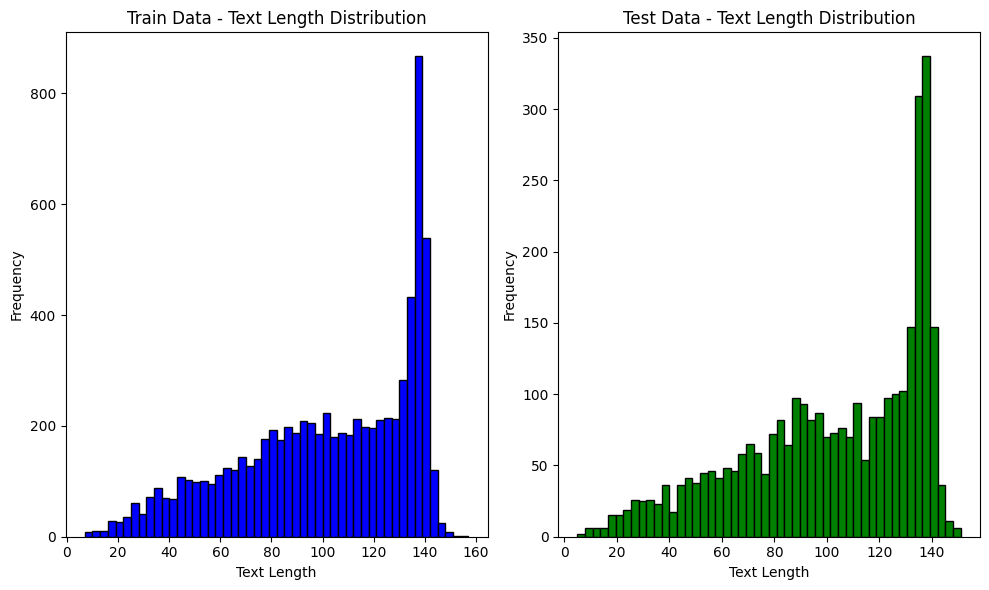

In [7]:
# Plotting Train Length Stat
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(train["length"], bins=50, color='blue', edgecolor='black')
plt.title('Train Data - Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Plotting Test Length Stat
plt.subplot(1, 2, 2)
plt.hist(test["length"], bins=50, color='green', edgecolor='black')
plt.title('Test Data - Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plots
plt.show()

**BERT NLP TOKENIZATION TASK**

In [8]:
batch_size = 64
num_training_examples = train.shape[0]
train_split = 0.8
val_split = 0.2
steps_per_epoch = int(num_training_examples) * train_split // batch_size

epochs = 2
auto = tf.data.experimental.AUTOTUNE

In [9]:
X = train["text"]
y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42)

X_test = test["text"]

In [10]:
import torch
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

# Tokenize and encode the training data
train_inputs = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt')
train_labels = torch.tensor(list(y_train))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
val_inputs = tokenizer(list(X_val), padding=True, truncation=True, return_tensors='pt')
val_labels = torch.tensor(list(y_val))

# Tokenize and encode the test data
test_inputs = tokenizer(list(test['text']), padding=True, truncation=True, return_tensors='pt')

# Create DataLoader for efficient processing
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
# Gradient Clipping
epochs = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

max_grad_norm = 1.0

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, inputs['labels'])
        loss.backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

Epoch 3/3: 100%|██████████| 762/762 [06:23<00:00,  1.99it/s]


In [15]:
model.eval()
val_preds = []
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc='Validation'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        val_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())

# Evaluate the model
print("Classification Report:")
print(classification_report(y_val, val_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_val, val_preds))
print("F1 Score:", f1_score(y_val, val_preds))

Validation: 100%|██████████| 191/191 [00:21<00:00,  8.75it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       874
           1       0.81      0.80      0.80       649

    accuracy                           0.83      1523
   macro avg       0.83      0.83      0.83      1523
weighted avg       0.83      0.83      0.83      1523

Confusion Matrix:
[[749 125]
 [129 520]]
F1 Score: 0.80370942812983


The F1 score in the provided output is 0.8188, indicating a good balance between precision and recall in the classification model.

In [16]:
model.eval()
test_preds = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Testing'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        test_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())

# Add predictions to the test_data DataFrame
test['target'] = test_preds

# Save the predictions to a CSV file
test[['id', 'target']].to_csv('predictions_bert.csv', index=False)

Testing: 100%|██████████| 408/408 [00:43<00:00,  9.32it/s]


In [17]:
print(test[['id', 'target']].head(5))
print(test['target'].value_counts())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
0    1918
1    1345
Name: target, dtype: int64


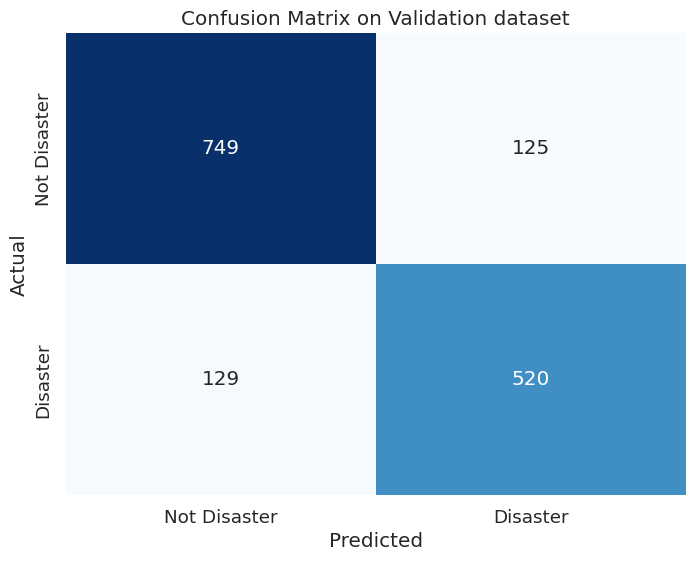

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have already calculated the confusion matrix
conf_matrix = confusion_matrix(y_val, val_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=["Not Disaster","Disaster"],
            yticklabels=["Not Disaster","Disaster"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation dataset')
plt.show()